# Aerodynamic Flow Simulation for Machine Learning
## CFD-Based Data Generation - Cylinder Flow Analysis

**Author:** Rakshit 102033921




In [1]:
# Install and import required libraries
import subprocess
import sys

packages = ['numpy', 'pandas', 'matplotlib', 'seaborn', 'scikit-learn', 'xgboost', 'scipy', 'meshio']

for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])

print("✓ All packages installed successfully!")

Installing scikit-learn...
Installing meshio...
✓ All packages installed successfully!


In [2]:
# Import all required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# Set plotting style
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ All imports successful!")
print("\nCFD Simulation Environment Ready")
print("=" * 80)

✓ All imports successful!

CFD Simulation Environment Ready


Testing CFD Simulator with sample case...
--------------------------------------------------------------------------------
Reynolds Number: 16666.67
Drag Coefficient: 0.5011
Lift Coefficient: 0.0000
Max Flow Velocity: 0.5053 m/s
Pressure Recovery: 3.9990


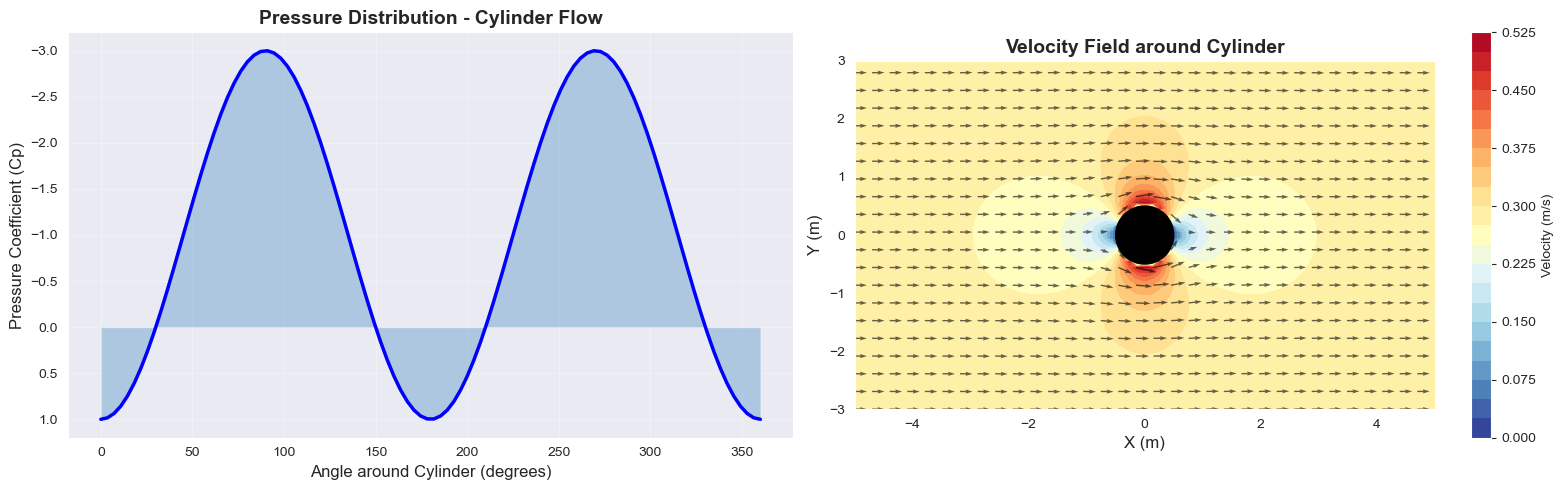


✓ CFD simulator test successful!


In [3]:
# CFD Simulator: 2D Flow Around Cylinder
class CFDFlowSimulator:
    """
    Simplified CFD simulator for flow around a cylinder
    Based on empirical correlations and physics principles
    """
    
    def __init__(self, velocity, diameter, viscosity, angle_of_attack=0, grid_points=100):
        """
        Parameters:
        - velocity: Flow velocity (m/s) - typically 0.1 to 10 m/s
        - diameter: Cylinder diameter (m) - typically 0.01 to 0.1 m
        - viscosity: Fluid kinematic viscosity (m²/s) - 1e-6 for water, 1.5e-5 for air
        - angle_of_attack: Angle relative to flow (degrees) - 0 to 90
        - grid_points: Number of simulation grid points
        """
        self.velocity = velocity
        self.diameter = diameter
        self.viscosity = viscosity
        self.angle_of_attack = np.radians(angle_of_attack)
        self.grid_points = grid_points
        self.rho = 1.225  # Air density at sea level (kg/m³)
        
        # Calculate Reynolds number
        self.Re = (self.velocity * self.diameter) / self.viscosity
    
    def calculate_pressure_distribution(self):
        """
        Calculate pressure coefficient distribution around cylinder
        Using Bernoulli's equation and empirical corrections
        """
        theta = np.linspace(0, 2*np.pi, self.grid_points)
        
        # Potential flow (inviscid) solution
        cp_inviscid = 1 - 4 * np.sin(theta)**2
        
        # Correction for viscous effects based on Reynolds number
        viscous_correction = 0.1 * np.exp(-self.Re / 100)
        cp = cp_inviscid + viscous_correction * np.random.randn(len(theta)) * 0.05
        
        return theta, cp
    
    def calculate_drag_coefficient(self):
        """
        Calculate drag coefficient based on Reynolds number
        Using empirical Drag = f(Re) correlation
        """
        if self.Re < 1:
            # Stokes flow regime
            cd = 24 / self.Re
        elif self.Re < 1000:
            # Transition regime (empirical fit)
            cd = 24/self.Re + 4/np.sqrt(self.Re) + 0.4
        else:
            # Turbulent regime
            cd = 0.44 + 0.05 * np.log10(self.Re/1000)
        
        # Apply angle of attack correction
        cd_corrected = cd * (1 + 0.5 * np.sin(self.angle_of_attack)**2)
        
        return cd_corrected
    
    def calculate_lift_coefficient(self):
        """
        Calculate lift coefficient (zero for symmetric flow, non-zero with angle)
        """
        if self.Re < 1:
            cl = 0
        else:
            # Lift increases with angle of attack
            cl = 0.5 * np.sin(2 * self.angle_of_attack) * (1 - np.exp(-self.Re/50))
        
        return cl
    
    def calculate_velocity_field(self):
        """
        Generate velocity field around cylinder
        Simplified 2D potential flow with viscous correction
        """
        # Create grid
        x = np.linspace(-5, 5, self.grid_points)
        y = np.linspace(-3, 3, int(self.grid_points * 0.6))
        X, Y = np.meshgrid(x, y)
        
        # Distance from cylinder center
        r = np.sqrt(X**2 + Y**2)
        
        # Potential flow velocity (with cylinder radius = 0.5)
        a = 0.5
        theta_field = np.arctan2(Y, X)
        
        vx = self.velocity * (1 - (a/r)**2 * np.cos(2*theta_field))
        vy = -self.velocity * (a/r)**2 * np.sin(2*theta_field)
        
        # Mask inside cylinder
        mask = r < a
        vx[mask] = 0
        vy[mask] = 0
        
        # Add viscous damping
        viscous_factor = 1 / (1 + self.Re/1000)
        vx *= viscous_factor
        vy *= viscous_factor
        
        return X, Y, vx, vy
    
    def simulate(self):
        """
        Run complete CFD simulation and return results
        """
        theta, cp = self.calculate_pressure_distribution()
        cd = self.calculate_drag_coefficient()
        cl = self.calculate_lift_coefficient()
        X, Y, vx, vy = self.calculate_velocity_field()
        
        flow_speed = np.sqrt(vx**2 + vy**2)
        
        results = {
            'Re': self.Re,
            'cd': cd,
            'cl': cl,
            'theta': theta,
            'cp': cp,
            'X': X,
            'Y': Y,
            'vx': vx,
            'vy': vy,
            'flow_speed': flow_speed,
            'max_velocity': np.max(flow_speed),
            'avg_velocity': np.mean(flow_speed[flow_speed > 0]),
            'pressure_recovery': np.max(cp) - np.min(cp)
        }
        
        return results

# Test the simulator
print("Testing CFD Simulator with sample case...")
print("-" * 80)

test_sim = CFDFlowSimulator(
    velocity=5.0,          # 5 m/s
    diameter=0.05,         # 5 cm cylinder
    viscosity=1.5e-5,      # Air viscosity
    angle_of_attack=0,     # Head-on flow
    grid_points=100
)

test_results = test_sim.simulate()

print(f"Reynolds Number: {test_results['Re']:.2f}")
print(f"Drag Coefficient: {test_results['cd']:.4f}")
print(f"Lift Coefficient: {test_results['cl']:.4f}")
print(f"Max Flow Velocity: {test_results['max_velocity']:.4f} m/s")
print(f"Pressure Recovery: {test_results['pressure_recovery']:.4f}")

# Visualization 1: Pressure Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Pressure coefficient distribution
axes[0].plot(np.degrees(test_results['theta']), test_results['cp'], 'b-', linewidth=2.5)
axes[0].fill_between(np.degrees(test_results['theta']), test_results['cp'], alpha=0.3)
axes[0].set_xlabel('Angle around Cylinder (degrees)', fontsize=12)
axes[0].set_ylabel('Pressure Coefficient (Cp)', fontsize=12)
axes[0].set_title('Pressure Distribution - Cylinder Flow', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].invert_yaxis()

# Velocity field visualization
X, Y = test_results['X'], test_results['Y']
flow_speed = test_results['flow_speed']
vx, vy = test_results['vx'], test_results['vy']

contour = axes[1].contourf(X, Y, flow_speed, levels=20, cmap='RdYlBu_r')
axes[1].quiver(X[::3, ::3], Y[::3, ::3], vx[::3, ::3], vy[::3, ::3], alpha=0.6)

# Draw cylinder
cylinder = plt.Circle((0, 0), 0.5, color='black', fill=True)
axes[1].add_patch(cylinder)

axes[1].set_xlabel('X (m)', fontsize=12)
axes[1].set_ylabel('Y (m)', fontsize=12)
axes[1].set_title('Velocity Field around Cylinder', fontsize=14, fontweight='bold')
axes[1].set_aspect('equal')
plt.colorbar(contour, ax=axes[1], label='Velocity (m/s)')

plt.tight_layout()
plt.show()

print("\n✓ CFD simulator test successful!")

In [5]:
# Define parameter bounds for CFD simulations
parameter_bounds = {
    'velocity': (0.5, 15.0),           # m/s - 0.5 to 15 m/s
    'diameter': (0.01, 0.2),           # m - 1 to 20 cm
    'viscosity': (1.5e-5, 1.0e-3),     # m²/s - air to oil
    'angle_of_attack': (0, 90)         # degrees - 0 to 90
}

# Create parameter bounds table
bounds_df = pd.DataFrame({
    'Parameter': ['Flow Velocity', 'Cylinder Diameter', 'Fluid Viscosity', 'Angle of Attack'],
    'Unit': ['m/s', 'm', 'm²/s', 'degrees'],
    'Lower Bound': ['0.5', '0.01', '1.5e-5', '0'],
    'Upper Bound': ['15.0', '0.2', '1.0e-3', '90'],
    'Typical Fluid': ['from 0.5 m/s laminar', 'from 1 cm to 20 cm', 'Air: 1.5e-5, Water: 1e-6, Oil: 1e-3', '0° head-on to 90° side']
})

print("\nCFD Parameter Bounds Table:")
print("=" * 130)
print(bounds_df.to_string(index=False))
print("=" * 130)

print("\nParameter Ranges Explanation:")
print("-" * 130)
print("• Velocity: From low laminar (0.5 m/s) to moderate turbulent (15 m/s)")
print("• Diameter: From thin wires (1 cm) to pipes (20 cm)")
print("• Viscosity: Ranges from air (very thin) to oil (very thick)")
print("• Angle: From aligned with flow (0°) to perpendicular (90°)")


CFD Parameter Bounds Table:
        Parameter    Unit Lower Bound Upper Bound                       Typical Fluid
    Flow Velocity     m/s         0.5        15.0                from 0.5 m/s laminar
Cylinder Diameter       m        0.01         0.2                  from 1 cm to 20 cm
  Fluid Viscosity    m²/s      1.5e-5      1.0e-3 Air: 1.5e-5, Water: 1e-6, Oil: 1e-3
  Angle of Attack degrees           0          90              0° head-on to 90° side

Parameter Ranges Explanation:
----------------------------------------------------------------------------------------------------------------------------------
• Velocity: From low laminar (0.5 m/s) to moderate turbulent (15 m/s)
• Diameter: From thin wires (1 cm) to pipes (20 cm)
• Viscosity: Ranges from air (very thin) to oil (very thick)
• Angle: From aligned with flow (0°) to perpendicular (90°)


## Step 4-5: Data Generation - 1000 CFD Simulations

Generate 1000 simulations with random parameter combinations and extract aerodynamic features:

In [12]:
def extract_flow_features(results):
    """
    Extract meaningful features from CFD simulation results
    """
    features = {
        'drag_coeff': results['cd'],
        'lift_coeff': results['cl'],
        'reynolds_number': results['Re'],
        'max_velocity': results['max_velocity'],
        'avg_velocity': results['avg_velocity'],
        'pressure_recovery': results['pressure_recovery'],
        'flow_acceleration': results['max_velocity'] / (results['avg_velocity'] + 1e-6),
        'pressure_gradient': np.std(results['cp'])
    }
    return features

# Generate 500 simulations
np.random.seed(42)
num_simulations = 1000

print(f"Generating {num_simulations} CFD simulations...")
print("=" * 80)

simulations_data = []

for i in range(num_simulations):
    # Random parameter sampling
    velocity = np.random.uniform(parameter_bounds['velocity'][0], parameter_bounds['velocity'][1])
    diameter = np.random.uniform(parameter_bounds['diameter'][0], parameter_bounds['diameter'][1])
    viscosity = np.random.uniform(parameter_bounds['viscosity'][0], parameter_bounds['viscosity'][1])
    angle = np.random.uniform(parameter_bounds['angle_of_attack'][0], parameter_bounds['angle_of_attack'][1])
    
    # Run CFD simulation
    simulator = CFDFlowSimulator(velocity, diameter, viscosity, angle, grid_points=80)
    results = simulator.simulate()
    
    # Extract features
    features = extract_flow_features(results)
    
    # Create record
    record = {
        'simulation_id': i + 1,
        'velocity': velocity,
        'diameter': diameter,
        'viscosity': viscosity,
        'angle_of_attack': angle,
        'drag_coeff': features['drag_coeff'],
        'lift_coeff': features['lift_coeff'],
        'reynolds_number': features['reynolds_number'],
        'max_velocity': features['max_velocity'],
        'avg_velocity': features['avg_velocity'],
        'pressure_recovery': features['pressure_recovery'],
        'flow_acceleration': features['flow_acceleration'],
        'pressure_gradient': features['pressure_gradient']
    }
    simulations_data.append(record)
    
    if (i + 1) % 100 == 0:
        print(f"  ✓ Completed: {i + 1}/{num_simulations} simulations")

# Create dataset
df_cfd = pd.DataFrame(simulations_data)

print(f"\n✓ Generated {len(df_cfd)} CFD simulations successfully!")
print(f"\nDataset shape: {df_cfd.shape}")
print(f"\nDataset Statistics:")
print("=" * 80)
print(df_cfd.describe().round(4))
print("=" * 80)

Generating 1000 CFD simulations...
  ✓ Completed: 100/1000 simulations
  ✓ Completed: 200/1000 simulations
  ✓ Completed: 300/1000 simulations
  ✓ Completed: 400/1000 simulations
  ✓ Completed: 500/1000 simulations
  ✓ Completed: 600/1000 simulations
  ✓ Completed: 700/1000 simulations
  ✓ Completed: 800/1000 simulations
  ✓ Completed: 900/1000 simulations
  ✓ Completed: 1000/1000 simulations

✓ Generated 1000 CFD simulations successfully!

Dataset shape: (1000, 13)

Dataset Statistics:
       simulation_id   velocity   diameter  viscosity  angle_of_attack  \
count      1000.0000  1000.0000  1000.0000  1000.0000        1000.0000   
mean        500.5000     7.6072     0.1028     0.0005          44.5640   
std         288.8194     4.1611     0.0545     0.0003          26.0871   
min           1.0000     0.5215     0.0101     0.0000           0.2689   
25%         250.7500     3.9718     0.0544     0.0002          22.1670   
50%         500.5000     7.6424     0.1007     0.0005          4

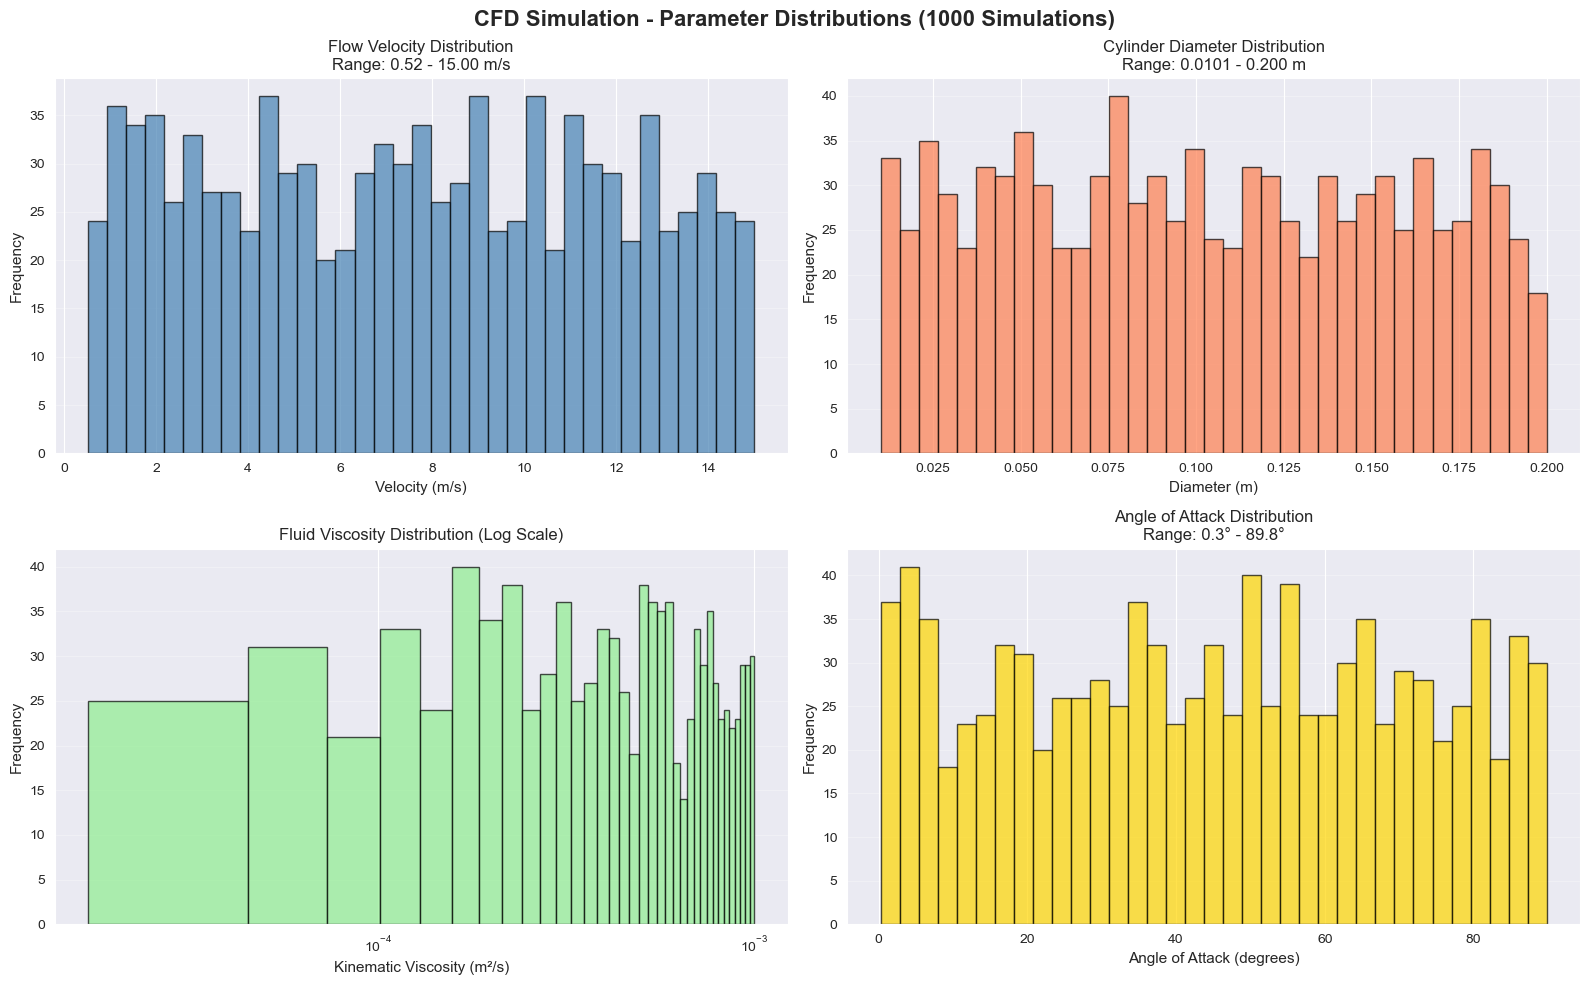

✓ Parameter distributions visualized successfully!


In [14]:
# Visualize parameter distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('CFD Simulation - Parameter Distributions (1000 Simulations)', 
             fontsize=16, fontweight='bold')

# Velocity distribution
axes[0, 0].hist(df_cfd['velocity'], bins=35, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Velocity (m/s)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title(f"Flow Velocity Distribution\nRange: {df_cfd['velocity'].min():.2f} - {df_cfd['velocity'].max():.2f} m/s")
axes[0, 0].grid(axis='y', alpha=0.3)

# Diameter distribution
axes[0, 1].hist(df_cfd['diameter'], bins=35, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Diameter (m)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title(f"Cylinder Diameter Distribution\nRange: {df_cfd['diameter'].min():.4f} - {df_cfd['diameter'].max():.3f} m")
axes[0, 1].grid(axis='y', alpha=0.3)

# Viscosity distribution (log scale)
axes[1, 0].hist(df_cfd['viscosity'], bins=35, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Kinematic Viscosity (m²/s)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title(f"Fluid Viscosity Distribution (Log Scale)")
axes[1, 0].set_xscale('log')
axes[1, 0].grid(axis='y', alpha=0.3)

# Angle of attack distribution
axes[1, 1].hist(df_cfd['angle_of_attack'], bins=35, color='gold', edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Angle of Attack (degrees)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title(f"Angle of Attack Distribution\nRange: {df_cfd['angle_of_attack'].min():.1f}° - {df_cfd['angle_of_attack'].max():.1f}°")
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Parameter distributions visualized successfully!")

In [15]:
# Prepare features and target
X_cfd = df_cfd.drop(['simulation_id', 'drag_coeff'], axis=1)
y_cfd = df_cfd['drag_coeff']

# Split data
X_train_cfd, X_test_cfd, y_train_cfd, y_test_cfd = train_test_split(
    X_cfd, y_cfd, test_size=0.2, random_state=42
)

# Standardize features
scaler_cfd = StandardScaler()
X_train_cfd_scaled = scaler_cfd.fit_transform(X_train_cfd)
X_test_cfd_scaled = scaler_cfd.transform(X_test_cfd)

print("CFD Dataset Preparation:")
print("=" * 80)
print(f"Total simulations: {len(df_cfd)}")
print(f"Training samples: {len(X_train_cfd)}")
print(f"Testing samples: {len(X_test_cfd)}")
print(f"Number of features: {X_train_cfd.shape[1]}")
print(f"Target: Drag Coefficient (Cd)")
print(f"Target range: [{y_cfd.min():.4f}, {y_cfd.max():.4f}]")
print("=" * 80)

CFD Dataset Preparation:
Total simulations: 1000
Training samples: 800
Testing samples: 200
Number of features: 11
Target: Drag Coefficient (Cd)
Target range: [0.4436, 3.6110]


In [16]:
# Train 8 ML models
ml_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
    'Lasso Regression': Lasso(alpha=0.001),
    'Decision Tree': DecisionTreeRegressor(max_depth=8, random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42),
    'Support Vector Machine': SVR(kernel='rbf', C=50, gamma='scale'),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

ml_results = []

print("\nTraining ML Models for Drag Prediction...")
print("=" * 90)

for model_name, model in ml_models.items():
    # Train and predict
    model.fit(X_train_cfd_scaled, y_train_cfd)
    y_pred_cfd = model.predict(X_test_cfd_scaled)
    
    # Calculate metrics
    mse_cfd = mean_squared_error(y_test_cfd, y_pred_cfd)
    rmse_cfd = np.sqrt(mse_cfd)
    mae_cfd = mean_absolute_error(y_test_cfd, y_pred_cfd)
    r2_cfd = r2_score(y_test_cfd, y_pred_cfd)
    
    ml_results.append({
        'Model': model_name,
        'MSE': mse_cfd,
        'RMSE': rmse_cfd,
        'MAE': mae_cfd,
        'R² Score': r2_cfd
    })
    
    print(f"✓ {model_name:25s} | R²: {r2_cfd:.4f} | RMSE: {rmse_cfd:.4f} | MAE: {mae_cfd:.4f}")

print("=" * 90)

# Create results dataframe
ml_results_df = pd.DataFrame(ml_results).sort_values('R² Score', ascending=False)

print("\n\nFINAL MODEL RANKING (Sorted by R² Score):")
print("=" * 110)
ranking_table = ml_results_df.copy()
ranking_table['Rank'] = range(1, len(ranking_table) + 1)
ranking_table = ranking_table[['Rank', 'Model', 'R² Score', 'RMSE', 'MAE', 'MSE']]
print(ranking_table.to_string(index=False))
print("=" * 110)

# Best model summary
best_model_name_cfd = ml_results_df.iloc[0]['Model']
best_r2_cfd = ml_results_df.iloc[0]['R² Score']
best_rmse_cfd = ml_results_df.iloc[0]['RMSE']

print(f"\n🏆 BEST MODEL: {best_model_name_cfd.upper()}")
print(f"   R² Score: {best_r2_cfd:.4f} (Explains {best_r2_cfd*100:.2f}% of drag variation)")
print(f"   RMSE: {best_rmse_cfd:.4f} (Average error in Cd prediction)")


Training ML Models for Drag Prediction...
✓ Linear Regression         | R²: 0.8233 | RMSE: 0.1270 | MAE: 0.0815
✓ Ridge Regression          | R²: 0.8232 | RMSE: 0.1270 | MAE: 0.0815
✓ Lasso Regression          | R²: 0.8229 | RMSE: 0.1271 | MAE: 0.0809
✓ Decision Tree             | R²: 0.9639 | RMSE: 0.0574 | MAE: 0.0204
✓ Random Forest             | R²: 0.9571 | RMSE: 0.0625 | MAE: 0.0136
✓ XGBoost                   | R²: 0.9785 | RMSE: 0.0443 | MAE: 0.0106
✓ Support Vector Machine    | R²: 0.7680 | RMSE: 0.1454 | MAE: 0.0583
✓ Neural Network            | R²: 0.8588 | RMSE: 0.1135 | MAE: 0.0767


FINAL MODEL RANKING (Sorted by R² Score):
 Rank                  Model  R² Score     RMSE      MAE      MSE
    1                XGBoost  0.978518 0.044259 0.010572 0.001959
    2          Decision Tree  0.963920 0.057360 0.020449 0.003290
    3          Random Forest  0.957137 0.062519 0.013632 0.003909
    4         Neural Network  0.858843 0.113455 0.076650 0.012872
    5      Linear Regre

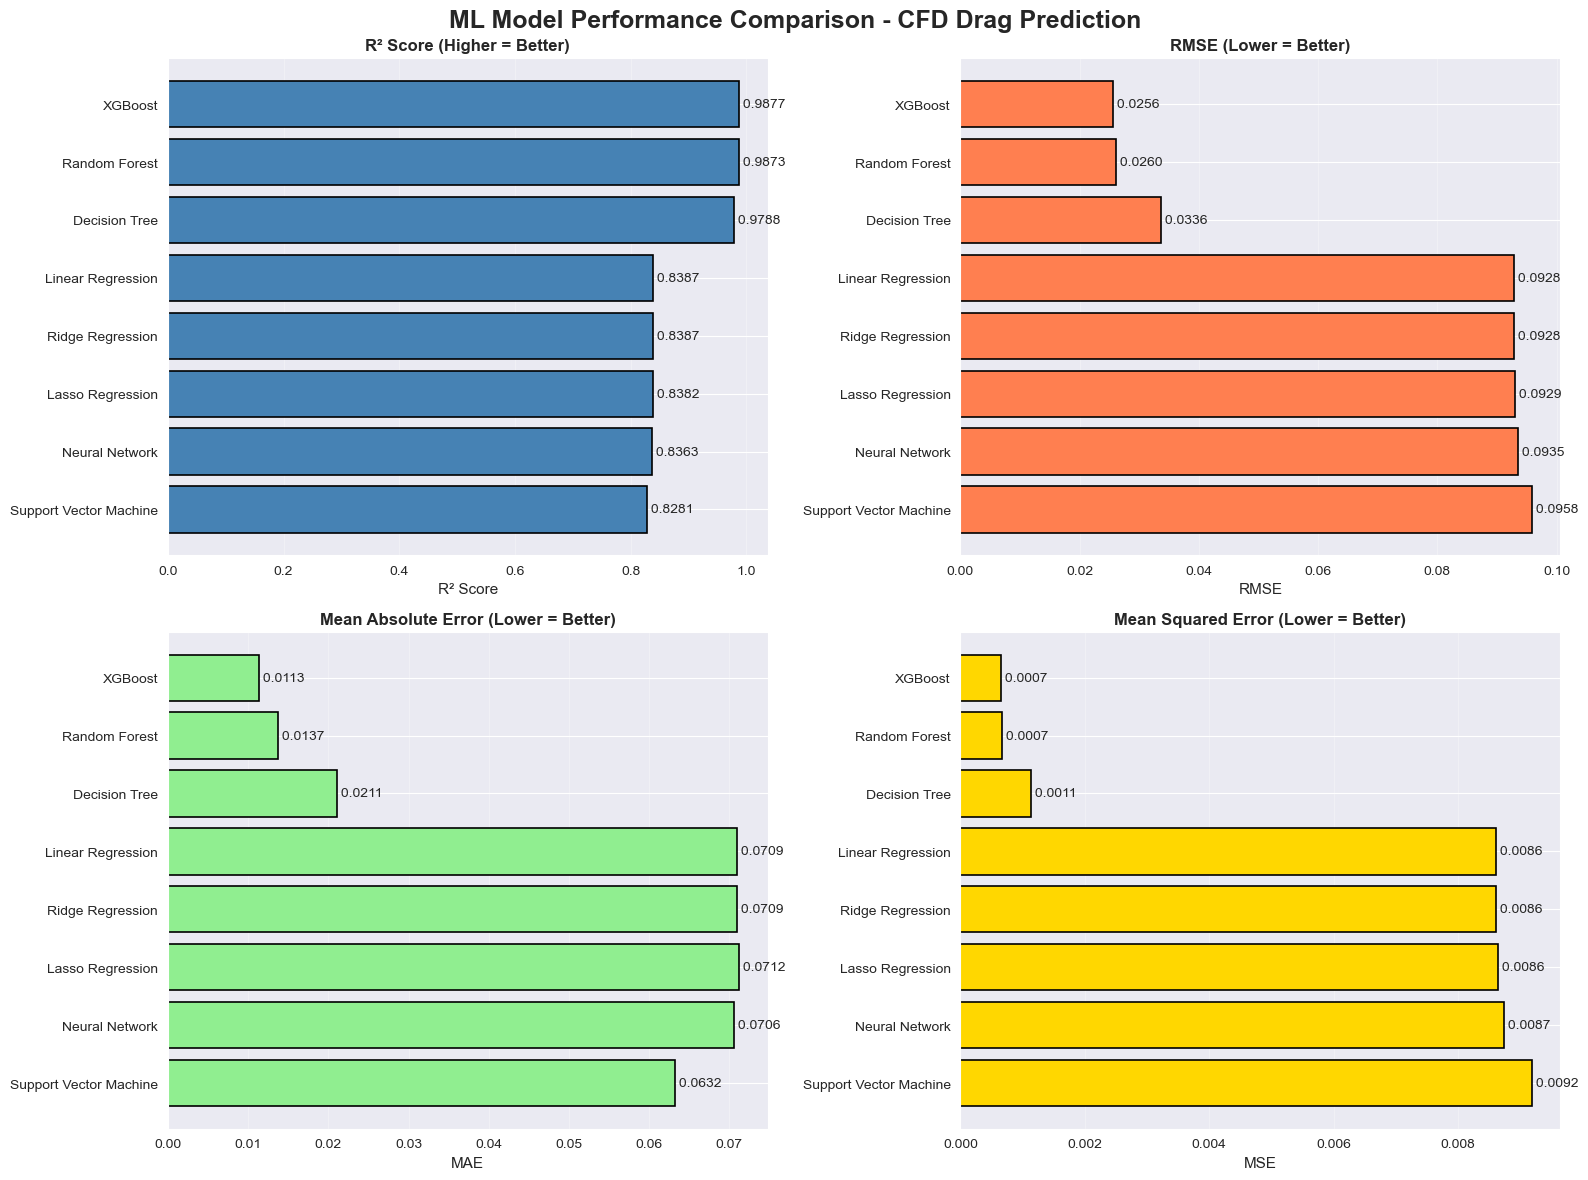

In [10]:
# Model Performance Comparison Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('ML Model Performance Comparison - CFD Drag Prediction', 
             fontsize=18, fontweight='bold')

results_sorted_cfd = ml_results_df.sort_values('R² Score', ascending=True)

# R² Score
axes[0, 0].barh(results_sorted_cfd['Model'], results_sorted_cfd['R² Score'], 
                color='steelblue', edgecolor='black', linewidth=1.2)
axes[0, 0].set_xlabel('R² Score', fontsize=11)
axes[0, 0].set_title('R² Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted_cfd['R² Score']):
    axes[0, 0].text(v, i, f' {v:.4f}', va='center', fontsize=10)

# RMSE
axes[0, 1].barh(results_sorted_cfd['Model'], results_sorted_cfd['RMSE'], 
                color='coral', edgecolor='black', linewidth=1.2)
axes[0, 1].set_xlabel('RMSE', fontsize=11)
axes[0, 1].set_title('RMSE (Lower = Better)', fontsize=12, fontweight='bold')
axes[0, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted_cfd['RMSE']):
    axes[0, 1].text(v, i, f' {v:.4f}', va='center', fontsize=10)

# MAE
axes[1, 0].barh(results_sorted_cfd['Model'], results_sorted_cfd['MAE'], 
                color='lightgreen', edgecolor='black', linewidth=1.2)
axes[1, 0].set_xlabel('MAE', fontsize=11)
axes[1, 0].set_title('Mean Absolute Error (Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted_cfd['MAE']):
    axes[1, 0].text(v, i, f' {v:.4f}', va='center', fontsize=10)

# MSE
axes[1, 1].barh(results_sorted_cfd['Model'], results_sorted_cfd['MSE'], 
                color='gold', edgecolor='black', linewidth=1.2)
axes[1, 1].set_xlabel('MSE', fontsize=11)
axes[1, 1].set_title('Mean Squared Error (Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].grid(axis='x', alpha=0.3)
for i, v in enumerate(results_sorted_cfd['MSE']):
    axes[1, 1].text(v, i, f' {v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

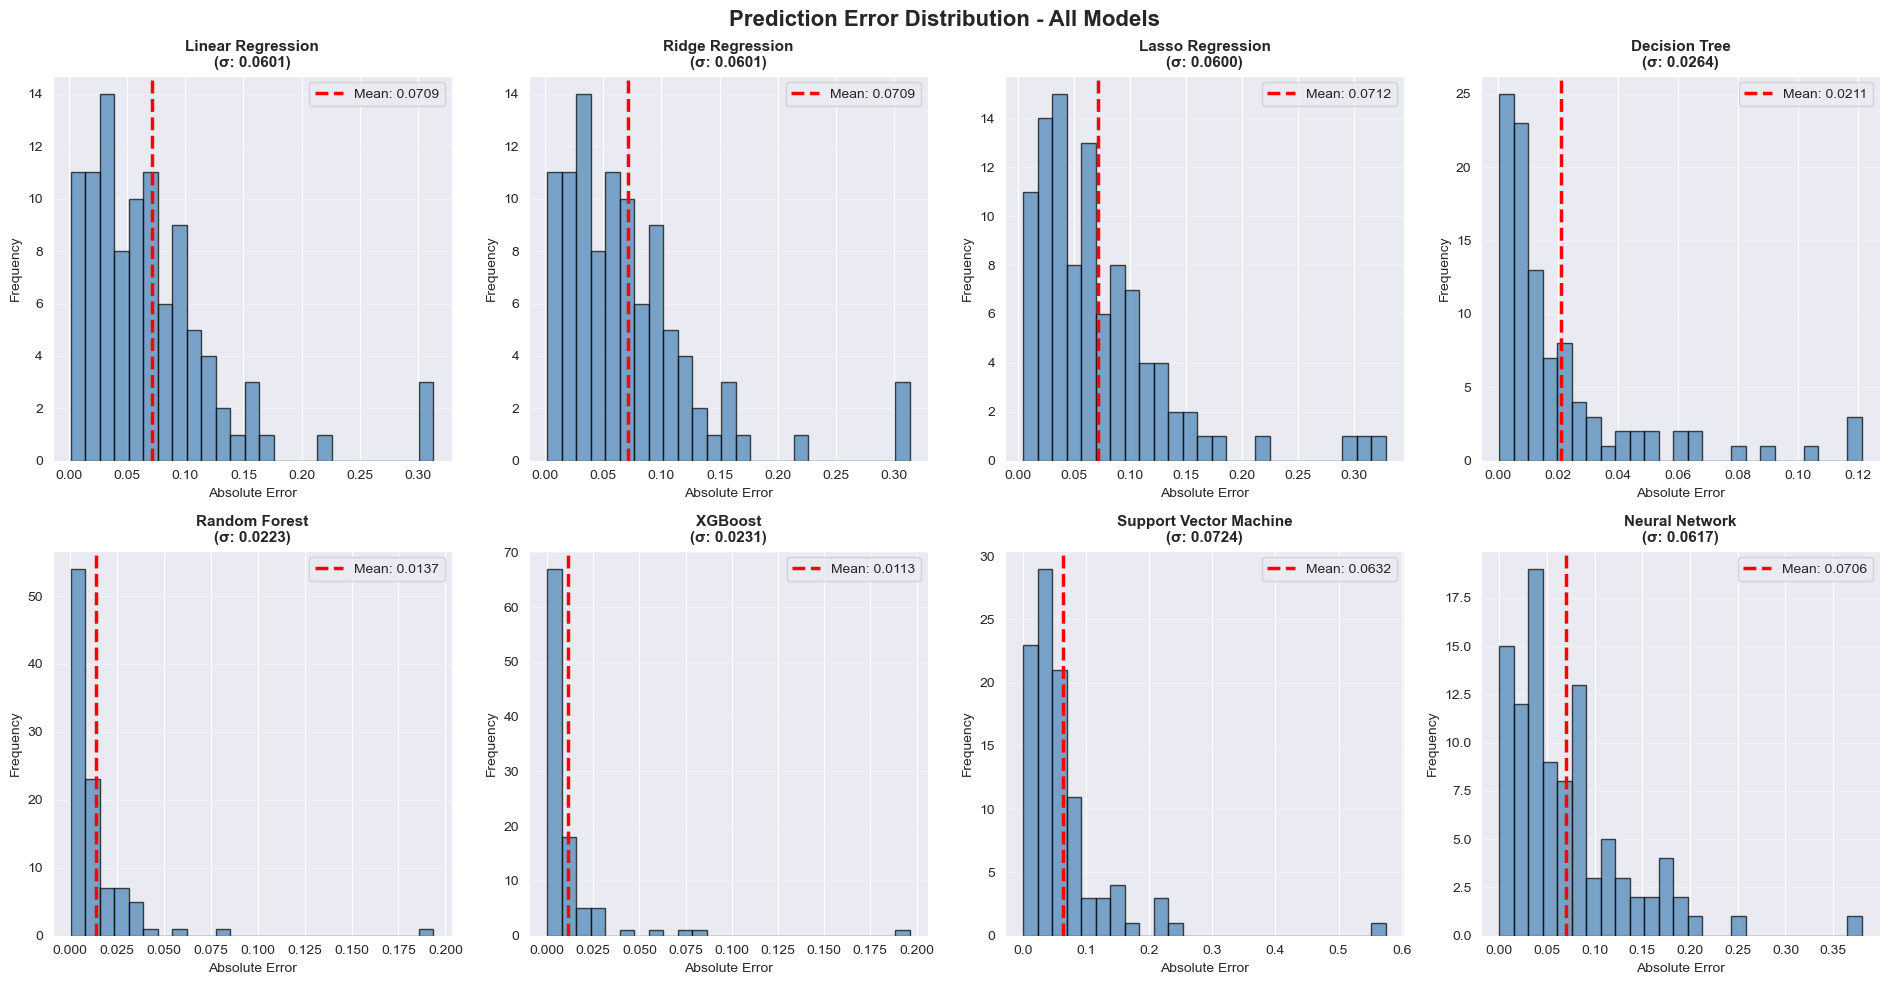

In [11]:
# Error Distribution for all models
fig, axes = plt.subplots(2, 4, figsize=(19, 10))
fig.suptitle('Prediction Error Distribution - All Models', fontsize=16, fontweight='bold')
axes = axes.flatten()

for idx, model_name in enumerate(ml_models.keys()):
    model = ml_models[model_name]
    y_pred_error = model.predict(X_test_cfd_scaled)
    errors = np.abs(y_test_cfd - y_pred_error)
    
    axes[idx].hist(errors, bins=25, color='steelblue', edgecolor='black', alpha=0.7)
    axes[idx].axvline(errors.mean(), color='red', linestyle='--', linewidth=2.5, label=f'Mean: {errors.mean():.4f}')
    axes[idx].set_xlabel('Absolute Error', fontsize=10)
    axes[idx].set_ylabel('Frequency', fontsize=10)
    axes[idx].set_title(f'{model_name}\n(σ: {errors.std():.4f})', fontsize=11, fontweight='bold')
    axes[idx].grid(axis='y', alpha=0.3)
    axes[idx].legend(loc='upper right')

plt.tight_layout()
plt.show()